# Running OTVelo on HARISSA simulations

This notebook shows how to reproduce results associated with the HARISSA dataset (Fig. 2)

In [ ]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import sys
import sklearn
sys.path.append('../Utils')
sys.path.append('../Data')
#import torch
from utils_Velo import *

from utils import *
import scipy
import matplotlib.pyplot as plt
import test_batch_HARISSA
from test_batch_HARISSA import batch_test
from test_batch_HARISSA import load_others_result
%load_ext autoreload
%autoreload 2

## Download datasets

Before running the algorithm, make sure to download the original data for HARISSA first.

They can be found from the GitHub repo of CARDAMOM: https://github.com/eliasventre/cardamom/tree/main/results_article/Benchmark_on_simulated_data

To make sure the following code runs, download the data above and put them under ../Data/HARISSA/. 


The block below shows how to run the two modalities OTVelo-Corr and OTVelo-Granger on the 9 datasets

In [ ]:
benchmarks = ['FN4', 'CN5','FN8','BN8']
benchmarks += ['Trees5', 'Trees10','Trees20','Trees50','Trees100']
for bn in benchmarks:
    
    # This runs OTVelo-Granger
    AUROC, AUPRC = batch_test(bn,list(range(1,11)), eps_samp=1E-2, save=True, modality='Granger',penalty='EN')#, tuning=True)

    # This runs OTVelo-Corr
    AUROC, AUPRC = batch_test(bn,list(range(1,11)), eps_samp=1E-2, save=True, modality='Corr')#, tuning=True)
    
    print( np.mean(AUROC)) 
    print(np.mean(AUPRC)) 

## Visualize results

After running the scripts, the resulting GRNs are automatically saved under Data/OTVelo-Corr and Data/OTVelo-Granger. We can quantify the performance via boxplots like Fig.2 in paper. Note that the results of other methods (HARISSA, CARDAMOM, GENIE3, SINCERITIES) are automatically loaded from files provided along with the dataset repo.

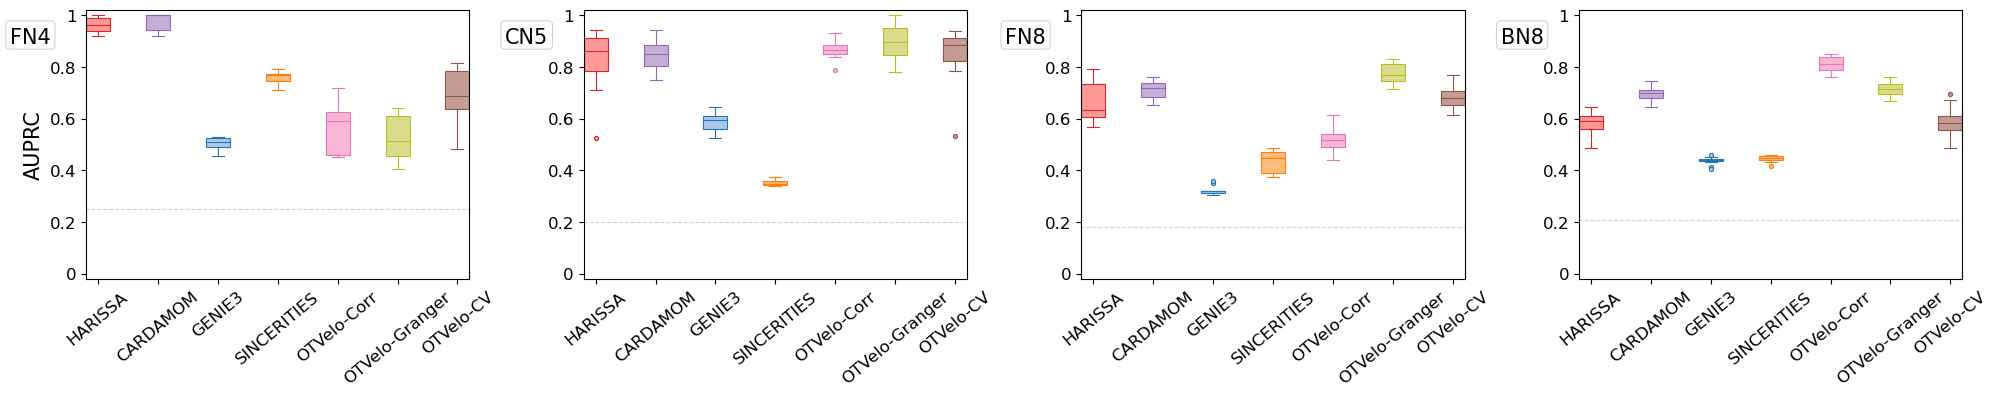

In [8]:
# Reproduce Figure 2

data = benchmarks
plt.rcParams["font.size"] = 16

sign = None
#sign = 'signed'
metric =  'AUPRC'


cmap = plt.get_cmap('tab20')
c = {'HARISSA': (cmap(6), cmap(7)), 'CARDAMOM': (cmap(8), cmap(9)),
    'GENIE3': (cmap(0), cmap(1)), 'SINCERITIES': (cmap(2), cmap(3)),
    'Random': 2*('lightgray',), 'OTVelo-CV': (cmap(10), cmap(11)),
    'OTVelo-Corr': (cmap(12),cmap(13)),'OTVelo-Granger': (cmap(16),cmap(17))}
opt_box = {'patch_artist': True, 'widths': [.4]}
def configure_box(box, c):
    w = 0.8
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box[item], color=c[0], lw=w)
    plt.setp(box['boxes'], facecolor=c[1])
    plt.setp(box['fliers'], markeredgecolor=c[0], ms=3, markerfacecolor=c[1],
        markeredgewidth=w)

plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (5*len(benchmarks),4)

methods_name = ['HARISSA','CARDAMOM','GENIE3','SINCERITIES','OTVelo-Corr','OTVelo-Granger','OTVelo-CV']#,'Ours l1 signed']#,'Ours tuned signed']   #,'Ours_l2','Ours_LOOCV']#,'Ours_tuned','Ours_corr_tuned']
    
if sign != None:
    # Remove GENIE3 from the comparison
    methods_name = ['HARISSA','CARDAMOM','SINCERITIES','OTVelo-Corr','OTVelo-Granger']#,'Ours l1 signed']#,'Ours tuned signed']    


dx = {None: 0.0,50:0.2,70:0.4}
counter = 0
n_data = len(data)
for example in data:
    counter += 1
    counter_method = -1
    ax = plt.subplot(1,n_data, counter)
    for method in methods_name:
        counter_method += 1
        if method!='OTVelo-Granger' and method!='OTVelo-CV':
            AUPRC, AUROC, EP, random = load_others_result(example,method, list(range(1,11)),sign = sign)
        #elif methods_name[counter_method][5:] == 'l1':
        #    AUPRC, AUROC, EP, random = load_others_result(example,method, list(range(1,11)),sign = sign,penalty='l1')
        elif method == 'OTVelo-Granger':
            
            AUPRC, AUROC, EP, random = load_others_result(example,method, list(range(1,11)),sign = sign,penalty='EN')
        else:
            AUPRC, AUROC, EP, random = load_others_result(example,'OTVelo-Granger', list(range(1,11)),sign = sign,penalty='CV')
        
            # print(AUPRC)
        
        
        if metric == 'AUPRC':
            box = ax.boxplot( AUPRC, positions = [counter_method], **opt_box )
        elif metric == 'AUROC':
            box = ax.boxplot( AUROC, positions = [counter_method], **opt_box )
            random = 0.5
        elif metric == 'EP':
            box = ax.boxplot( EP, positions = [counter_method], **opt_box )
        configure_box(box, c[methods_name[counter_method]])
        
    ax.plot([-1,10], [random,random], color='lightgray', ls='--', lw=0.8, zorder=0)
    
    
    plt.xlim([-0.2, len(methods_name)+0.2-1  ])
    ax.set_xticklabels(methods_name,fontsize=12, rotation=40)
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=12)

    if metric == 'AUROC':
        plt.ylim([0.4,1.02])
    else:
        plt.ylim([-0.02,1.02])

    x, y = -11, 10
    xn, yn = -0.142, 0.875
    optn = {'fontsize': 15, 'transform': ax.transAxes, 'ha': 'right'}
    if sign == None or sign == 'signed':
        ax.text(xn+0.05, yn, example, **optn)
        ax.text(xn+0.05, yn+0.01, example, color='none', zorder=0, bbox=dict(
                boxstyle='round,pad=0.2',fc='none',ec='lightgray',lw=0.8), **optn)
        if counter == 1:
            if sign == None:
                ax.set_ylabel(metric,fontsize=15)
            else:
                ax.set_ylabel(metric+' (signed)',fontsize=15)
plt.tight_layout()
plt.show()
#plt.savefig('../Results/HARISSA/AUPRC.pdf',dpi=1000)


Hyperparameter tuning for OTVelo-Corr: run a search over grid:


$$\alpha\in \{ 0, 0.25,0.5,0.75, 1.0\},$$ and $$\epsilon \in \{ 1E-3, 5E-3, 1E-2, 5E-2, 1E-1\}.$$

The $\alpha$ parameter controls the ratio between OT term and GWOT term and the quality of the resulting velocity field.

The $\epsilon$ parameter controls the sparsity of coupling matrix.



In [ ]:
benchmarks = ['FN4', 'CN5', 'FN8', 'BN8']


alpha_grid = [0.,0.25,0.5,0.75,1.0]
eps_grid = [1E-3,5E-3,1E-2,5E-2,1E-1]

# benchmarks = ['FN4', 'CN5', 'Trees5']
for bn in benchmarks:
    for alpha in alpha_grid:
        for eps in eps_grid:
            AUROC, AUPRC = batch_test(bn,list(range(1,11)), eps_samp=eps, alpha=alpha, modality='Corr', save=True, tuning=True)
            
    print( np.mean(AUROC)) 
    print(np.mean(AUPRC)) 

Reproduce the pixel plot for accuracy

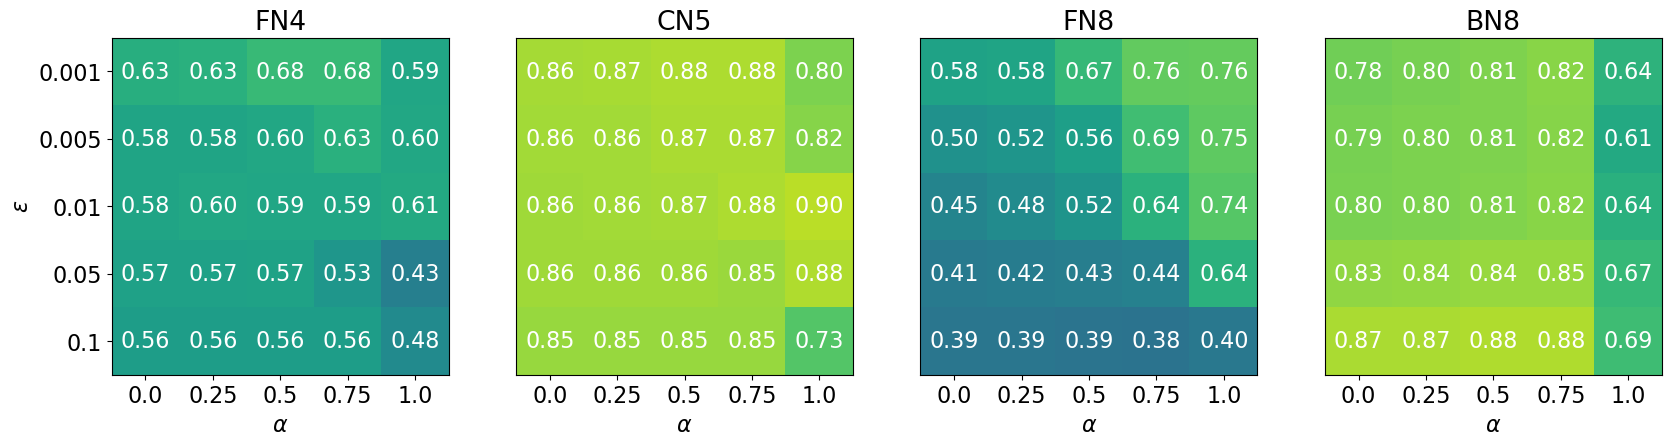

In [9]:
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["font.size"] = 16
alpha_grid = [0.,0.25, 0.5,0.75,1.0]
eps_grid = [1E-3, 5E-3, 1E-2, 5E-2, 1E-1]
benchmarks = ['FN4','CN5', 'FN8', 'BN8']#,
    # 'Trees5', 'Trees10', 'Trees20', 'Trees50', 'Trees100']
# benchmarks = ['FN4', 'CN5', 'Trees5']

#example = 'Trees100'
example_id = 0
example = benchmarks[example_id]
medians = [0]*len(benchmarks)#np.zeros( (5,5) )
medians_OT = np.zeros( (1,5) )
for example_id in range(len(benchmarks)):
   example = benchmarks[example_id]
   medians[example_id] = [0]
   medians[example_id] = np.zeros( (5,5) )
   for i in range(5):
           for j in range(5):
               AUPRC, AUROC, EP, random = load_others_result(example, 'OTVelo-Corr', list(range(1,11)), eps_samp=eps_grid[i], alpha=alpha_grid[j], sign=None, tune=True)
               medians[example_id][i,j] = np.median( AUPRC )



for example_id in range(4):
   ax = plt.subplot(1,4, example_id+1)
   plt.imshow( medians[example_id] )
   for i in range(5):
       for j in range(5):
           text = ax.text(j, i, '{:.2f}'.format(medians[example_id][i,j]),
                          ha="center", va="center", color="w")
   ax.set_xticks(range(5))
   ax.set_xticklabels( alpha_grid)
   ax.set_yticks([])

   plt.xlabel(r'$\alpha$')
   if example_id == 0:
       plt.ylabel(r'$\epsilon$')
       ax.set_yticks(range(5))
       ax.set_yticklabels( eps_grid)
   plt.clim([0,1])
   plt.title(benchmarks[example_id] )


#plt.savefig('../Results/HARISSA/parameter.pdf',dpi=1000)
plt.show()

In [11]:
from test_batch_HARISSA import tune_regression
benchmarks = ['FN4', 'CN5', 'FN8', 'BN8']#,
#benchmarks = benchmarks + [   'Trees5', 'Trees10', 'Trees20', 'Trees50', 'Trees100']
# benchmarks = ['FN4', 'CN5', 'Trees5']
for bn in benchmarks:
    _ = tune_regression(bn,list(range(1,11)), eps_samp=1E-2, save=True)#, tuning=True)
    

(5, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(5, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(5, 1000)
(5, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(5, 1000)
(5, 1000)
(5, 1000)
(5, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(5, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(5, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(6, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(6, 1000)
(6, 1000)
(6, 1000)
(6, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(6, 1000)
(6, 1000)
(6, 1000)
(6, 1000)
(6, 1000)
(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wenjunzhao/opt/anaconda3/lib/p

(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wenjunzhao/opt/anaconda3/lib/p

(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model 

(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model 

(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: 

(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(9, 1000)
(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(9, 1000)
(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(9, 1000)
(9, 1000)
(9, 1000)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


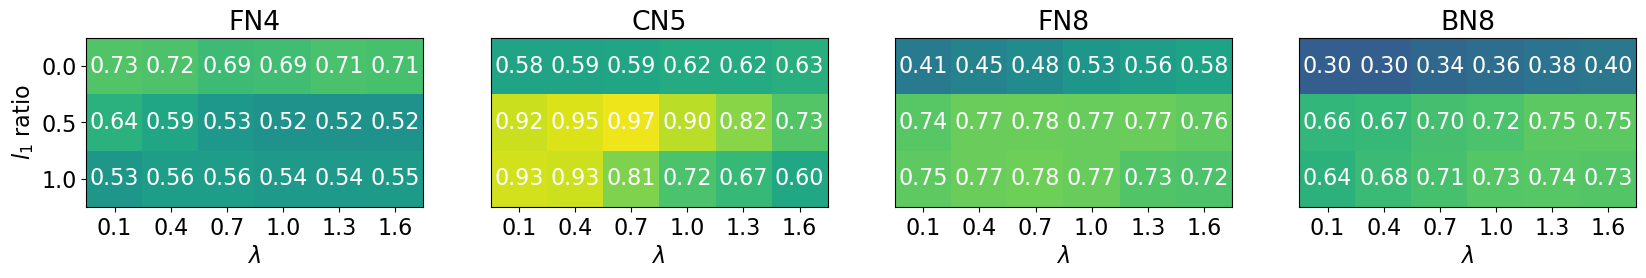

In [16]:
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["font.size"] = 16

lam_grid = [0.1,0.4,0.7,1.0,1.3,1.6]
l1_grid = [0.,0.5,1.] 

benchmarks = ['FN4','CN5', 'FN8', 'BN8']#,
    # 'Trees5', 'Trees10', 'Trees20', 'Trees50', 'Trees100']
# benchmarks = ['FN4', 'CN5', 'Trees5']

#example = 'Trees100'
example_id = 0
example = benchmarks[example_id]
medians = [0]*len(benchmarks)#np.zeros( (5,5) )
medians_OT = np.zeros( (1,5) )

for example_id in range(len(benchmarks)):
   example = benchmarks[example_id]
   medians[example_id] = [0]
   medians[example_id] = np.zeros( ( 3 ,6) )
   for i in range( len(l1_grid) ):
           for j in range( len(lam_grid) ):
               AUPRC, AUROC, EP, random = load_others_result(example, 'OTVelo-Granger', list(range(1,11)), l1=l1_grid[i], lam=lam_grid[j],  tune=True)
               medians[example_id][i,j] = np.median( AUPRC )



for example_id in range(4):
   ax = plt.subplot(1,4, example_id+1)
   plt.imshow( medians[example_id] )
   for i in range(3):
       for j in range(6):
           text = ax.text(j, i, '{:.2f}'.format(medians[example_id][i,j]),
                          ha="center", va="center", color="w")
   ax.set_xticks(range(6))
   ax.set_xticklabels( lam_grid)
   ax.set_yticks([])

   plt.xlabel(r'$\lambda$')
   if example_id == 0:
       plt.ylabel(r'$l_1$ ratio')
       ax.set_yticks(range(3))
       ax.set_yticklabels( l1_grid)
   plt.clim([0,1])
   plt.title(benchmarks[example_id] )
#plt.savefig('../Results/HARISSA/parameter_regression.pdf',dpi=1000)
plt.show()


